In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# pandas 출력 옵션
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

### # 특이사항 메모



---

### 주제탐색1 - 날짜별 가격변화를 예측?

##### 데이터 구조 탐색

- 날짜별 가격변화를 예측하면 성수기 여부에 따른 가격을 예측 가능

In [ ]:
# 날짜별 정보

df_calendar = pd.read_csv('./data/calendar.csv.gz', compression='gzip')

In [ ]:
# .info()를 통해 '숙소 고유 식별번호', '날짜', '가격', '가격 변동'등이 존재 함을 확인

df_calendar.info()

_="""
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8306219 entries, 0 to 8306218
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64      # 👈 숙소 고유 식별번호
 1   date            object     # 👈 날짜
 2   available       object     # 예약 가능 여부
 3   price           object     # 👈 가격
 4   adjusted_price  float64    # 👈 할인이나 프로모션 등이적용된 가격
 5   minimum_nights  float64    # 해당 날짜에 숙소를 예약하기 위해 필요한 최소 숙박 일수
 6   maximum_nights  float64    # 해당 날짜에 숙소를 예약할 수 있는 최대 숙박 일수
dtypes: float64(3), int64(1), object(3)
memory usage: 443.6+ MB
"""

In [ ]:
# 컬럼 'df_calendar['price']'가 object 타입이고 실제 데이터가 '$4,725.00' 와 같이 들어 있음을 발견하려 float형 컬럼 추가
price_float = 'price_float'
# 'price_float' 컬럼에서 '$'와 ',' 제거
df_calendar[price_float] = df_calendar['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)

# 컬럼 타입 변경
df_calendar[price_float] = df_calendar[price_float].astype(float)

In [ ]:
# df_calendar.loc[df_calendar['listing_id'] == 197677].describe()
# 가격변화를 보기위해 숙소 최빈값을 검색

print(df_calendar['listing_id'].mode())
_="""결과
0                 4690684       # 👈 분석대상
1                 5738050       # 👈 분석대상
...
51    1342364577456789638
Name: listing_id, dtype: int64
"""

In [ ]:
# 최빈값 2개에 대하여 ".describe()" 실행했지만 가격 변동이 없었음

df_calendar.loc[df_calendar['listing_id'] == 4690684].describe()

df_calendar.loc[df_calendar['listing_id'] == 5738050].describe()

_="""                                                                  [👇]
       listing_id  adjusted_price  minimum_nights  maximum_nights  price_float
count       366.0             0.0           365.0           365.0        366.0
mean    4690684.0             NaN            14.0           120.0       4725.0
std           0.0             NaN             0.0             0.0          0.0
min     4690684.0             NaN            14.0           120.0       4725.0
25%     4690684.0             NaN            14.0           120.0       4725.0
50%     4690684.0             NaN            14.0           120.0       4725.0
75%     4690684.0             NaN            14.0           120.0       4725.0
max     4690684.0             NaN            14.0           120.0       4725.0
       listing_id  adjusted_price  minimum_nights  maximum_nights  price_float
count       366.0             0.0           365.0           365.0        366.0
mean    5738050.0             NaN             3.0          1125.0       5500.0
std           0.0             NaN             0.0             0.0          0.0
min     5738050.0             NaN             3.0          1125.0       5500.0
25%     5738050.0             NaN             3.0          1125.0       5500.0
50%     5738050.0             NaN             3.0          1125.0       5500.0
75%     5738050.0             NaN             3.0          1125.0       5500.0
max     5738050.0             NaN             3.0          1125.0       5500.0
"""

---

##### **중간정리**
- 날짜별 가격변화를 예측 = 불가 판단
- 데이터셑 및 주제 변경

---

### 주제탐색2 - 숙소 조건에 따른 숙소 가격 예측

##### 1. 데이터 로드

In [ ]:

df_listings = pd.read_csv('./data/listings.csv.gz', compression='gzip')

##### 2. 데이터 구조 및 기초 통계 확인

In [ ]:
# 데이터 구조 분석
df_listings.info()

_="""
데이터 총: 25,297
컬럼 총: 79개
"""

# df_listings.describe()

##### - 전체 컬럼 리스트
- 회의롤 통해 1차적으로 필요/불필요 컬럼을 구별

In [ ]:
# 전체 컬럼
all_columns = {
    'id': '각 숙소의 고유 식별자',
    'listing_url': '숙소의 웹페이지 URL',
    'scrape_id': '데이터 스크래핑 작업의 고유 식별자',
    'last_scraped': '숙소 정보가 마지막으로 스크래핑된 날짜',
    'source': '숙소 정보의 출처',
    'name': '숙소의 이름',
    'description': '숙소에 대한 상세 설명',
    'neighborhood_overview': '숙소 주변 지역에 대한 설명',
    'picture_url': '숙소 대표 사진의 URL',
    'host_id': '호스트의 고유 식별자',
    'host_url': '호스트의 웹페이지 URL',
    'host_name': '호스트의 이름',
    'host_since': '호스트가 에어비앤비에 가입한 날짜',
    'host_location': '호스트의 위치',
    'host_about': '호스트에 대한 자기소개',
    'host_response_time': '호스트의 평균 응답 시간',
    'host_response_rate': '호스트의 응답률',
    'host_acceptance_rate': '호스트의 예약 수락률',
    'host_is_superhost': '호스트가 슈퍼호스트인지 여부',
    'host_thumbnail_url': '호스트 프로필 썸네일 이미지의 URL',
    'host_picture_url': '호스트 프로필 사진의 URL',
    'host_neighbourhood': '호스트가 거주하는 지역',
    'host_listings_count': '해당 호스트가 보유한 전체 숙소 수',
    'host_total_listings_count': '해당 호스트가 소유하거나 관리하는 전체 숙소 수',
    'host_verifications': '호스트의 인증 정보 목록',
    'host_has_profile_pic': '호스트가 프로필 사진을 가지고 있는지 여부',
    'host_identity_verified': '호스트 신원이 인증되었는지 여부',
    'neighbourhood': '숙소가 위치한 지역의 이름',
    'neighbourhood_cleansed': '정제된 숙소 지역 이름',
    'neighbourhood_group_cleansed': '정제된 숙소 지역 그룹 이름',
    'latitude': '숙소의 위도',
    'longitude': '숙소의 경도',
    'property_type': '숙소의 종류',
    'room_type': '숙소의 방 유형',
    'accommodates': '숙소가 수용 가능한 최대 인원 수',
    'bathrooms': '숙소의 욕실 개수',
    'bathrooms_text': '숙소의 욕실 개수를 설명하는 텍스트',
    'bedrooms': '숙소의 침실 개수',
    'beds': '숙소의 침대 개수',
    'amenities': '숙소에 제공되는 편의 시설 목록',
    'price': '숙소의 1박당 가격',
    'minimum_nights': '최소 숙박 가능 일수',
    'maximum_nights': '최대 숙박 가능 일수',
    'minimum_minimum_nights': '호스트가 설정한 최소 숙박 일수 중 가장 낮은 값',
    'maximum_minimum_nights': '호스트가 설정한 최소 숙박 일수 중 가장 높은 값',
    'minimum_maximum_nights': '호스트가 설정한 최대 숙박 일수 중 가장 낮은 값',
    'maximum_maximum_nights': '호스트가 설정한 최대 숙박 일수 중 가장 높은 값',
    'minimum_nights_avg_ntm': '최소 숙박 일수의 평균값',
    'maximum_nights_avg_ntm': '최대 숙박 일수의 평균값',
    'calendar_updated': '달력이 마지막으로 업데이트된 시점',
    'has_availability': '숙소 예약 가능 여부',
    'availability_30': '향후 30일 동안의 숙소 예약 가능 일수',
    'availability_60': '향후 60일 동안의 숙소 예약 가능 일수',
    'availability_90': '향후 90일 동안의 숙소 예약 가능 일수',
    'availability_365': '향후 365일 동안의 숙소 예약 가능 일수',
    'calendar_last_scraped': '달력 정보가 마지막으로 스크래핑된 날짜',
    'number_of_reviews': '총 리뷰 개수',
    'number_of_reviews_ltm': '지난 12개월 동안의 리뷰 개수',
    'number_of_reviews_l30d': '지난 30일 동안의 리뷰 개수',
    'availability_eoy': '연말까지의 예약 가능 일수',
    'number_of_reviews_ly': '지난 1년 동안의 리뷰 개수',
    'estimated_occupancy_l365d': '지난 365일 동안의 예상 점유율',
    'estimated_revenue_l365d': '지난 365일 동안의 예상 수입',
    'first_review': '첫 번째 리뷰가 작성된 날짜',
    'last_review': '마지막 리뷰가 작성된 날짜',
    'review_scores_rating': '총 리뷰 점수(별점)의 평균값',
    'review_scores_accuracy': '정확도 리뷰 점수',
    'review_scores_cleanliness': '청결도 리뷰 점수',
    'review_scores_checkin': '체크인 경험 리뷰 점수',
    'review_scores_communication': '소통 리뷰 점수',
    'review_scores_location': '위치 리뷰 점수',
    'review_scores_value': '가격 대비 가치 리뷰 점수',
    'license': '숙소의 라이선스 정보',
    'instant_bookable': '즉시 예약이 가능한 숙소인지 여부',
    'calculated_host_listings_count': '호스트가 등록한 숙소 개수',
    'calculated_host_listings_count_entire_homes': '호스트가 등록한 \'전체 숙소/아파트\' 유형의 개수',
    'calculated_host_listings_count_private_rooms': '호스트가 등록한 \'개인실\' 유형의 개수',
    'calculated_host_listings_count_shared_rooms': '호스트가 등록한 \'공용 공간\' 유형의 개수',
    'reviews_per_month': '월별 평균 리뷰 개수'
}

# 드롭 컬럼, host_id는 분석에 쓰임 분석 후 드롭 예정
drop_list = [
'id',	                                        # 각 숙소의 고유 식별자
'listing_url',	                                # 숙소의 웹페이지 URL
'scrape_id',	                                # 데이터 스크래핑 작업의 고유 식별자
'last_scraped',	                                # 숙소 정보가 마지막으로 스크래핑된 날짜
'source',	                                    # 숙소 정보의 출처
'name',	                                        # 숙소의 이름
'description',	                                # 숙소에 대한 상세 설명
'neighborhood_overview',	                    # 숙소 주변 지역에 대한 설명
'picture_url',	                                # 숙소 대표 사진의 URL
# 'host_id',	                                    # 호스트의 고유 식별자
'host_url',	                                    # 호스트의 웹페이지 URL
'host_name',	                                # 호스트의 이름
'host_since',	                                # 호스트가 에어비앤비에 가입한 날짜
'host_location',	                            # 호스트의 위치
'host_about',	                                # 호스트에 대한 자기소개
'host_response_time',	                        # 호스트의 평균 응답 시간
'host_response_rate',	                        # 호스트의 응답률
'host_acceptance_rate',	                        # 호스트의 예약 수락률
'host_is_superhost',	                        # 호스트가 슈퍼호스트인지 여부
'host_thumbnail_url',	                        # 호스트 프로필 썸네일 이미지의 URL
'host_picture_url',	                            # 호스트 프로필 사진의 URL
'host_neighbourhood',	                        # 호스트가 거주하는 지역
'host_listings_count',	                        # 해당 호스트가 보유한 전체 숙소 수
'host_total_listings_count',	                # 해당 호스트가 소유하거나 관리하는 전체 숙소 수
'host_verifications',	                        # 호스트의 인증 정보 목록
'host_has_profile_pic',	                        # 호스트가 프로필 사진을 가지고 있는지 여부
'host_identity_verified',	                    # 호스트 신원이 인증되었는지 여부
'neighbourhood',	                            # 숙소가 위치한 지역의 이름
'neighbourhood_group_cleansed',	                # 정제된 숙소 지역 그룹 이름
'bathrooms_text',	                            # 숙소의 욕실 개수를 설명하는 텍스트
'minimum_nights',	                            # 최소 숙박 가능 일수
'maximum_nights',	                            # 최대 숙박 가능 일수
'minimum_minimum_nights',	                    # 호스트가 설정한 최소 숙박 일수 중 가장 낮은 값
'maximum_minimum_nights',	                    # 호스트가 설정한 최소 숙박 일수 중 가장 높은 값
'minimum_maximum_nights',	                    # 호스트가 설정한 최대 숙박 일수 중 가장 낮은 값
'maximum_maximum_nights',	                    # 호스트가 설정한 최대 숙박 일수 중 가장 높은 값
'minimum_nights_avg_ntm',	                    # 최소 숙박 일수의 평균값
'maximum_nights_avg_ntm',	                    # 최대 숙박 일수의 평균값
'calendar_updated',	                            # 달력이 마지막으로 업데이트된 시점
'has_availability',	                            # 숙소 예약 가능 여부
'availability_30',	                            # 향후 30일 동안의 숙소 예약 가능 일수
'availability_60',	                            # 향후 60일 동안의 숙소 예약 가능 일수
'availability_90',	                            # 향후 90일 동안의 숙소 예약 가능 일수
'availability_365',	                            # 향후 365일 동안의 숙소 예약 가능 일수
'calendar_last_scraped',	                    # 달력 정보가 마지막으로 스크래핑된 날짜
'availability_eoy',	                            # 연말까지의 예약 가능 일수
'estimated_occupancy_l365d',	                # 지난 365일 동안의 예상 점유율
'estimated_revenue_l365d',	                    # 지난 365일 동안의 예상 수입
'license',	                                    # 숙소의 라이선스 정보
'instant_bookable',	                            # 즉시 예약이 가능한 숙소인지 여부
'calculated_host_listings_count',	            # 호스트가 등록한 숙소 개수
'calculated_host_listings_count_entire_homes',	# 호스트가 등록한 '전체 숙소/아파트' 유형의 개수
'calculated_host_listings_count_private_rooms',	# 호스트가 등록한 '개인실' 유형의 개수
'calculated_host_listings_count_shared_rooms',	# 호스트가 등록한 '공용 공간' 유형의 개수
'reviews_per_month'	                            # 월별 평균 리뷰 개수
]


In [ ]:

# 불필요 컬럼 드롭 처리
df_listings = df_listings.drop(drop_list, axis=1)


In [ ]:
# 불필요 컬럼 드롭 후 컬럼 상세 분석

df_listings.info()

_="""
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25297 entries, 0 to 25296
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neighbourhood_cleansed       25297 non-null  object 
 1   latitude                     25297 non-null  float64
 2   longitude                    25297 non-null  float64
 3   property_type                25297 non-null  object 
 4   room_type                    25297 non-null  object 
 5   accommodates                 25297 non-null  int64  
 6   bathrooms                    23253 non-null  float64
 7   bedrooms                     25040 non-null  float64
 8   beds                         23255 non-null  float64
 9   amenities                    25297 non-null  object 
 10  price                        23260 non-null  object
 11  number_of_reviews            25297 non-null  int64  
 12  number_of_reviews_ltm        25297 non-null  int64  
 13  number_of_reviews_l30d       25297 non-null  int64  
 14  number_of_reviews_ly         25297 non-null  int64  
 15  first_review                 21724 non-null  object
 16  last_review                  21724 non-null  object
 17  review_scores_rating         21724 non-null  float64
 18  review_scores_accuracy       21720 non-null  float64
 19  review_scores_cleanliness    21720 non-null  float64
 20  review_scores_checkin        21720 non-null  float64
 21  review_scores_communication  21720 non-null  float64
 22  review_scores_location       21720 non-null  float64
 23  review_scores_value          21720 non-null  float64
dtypes: float64(12), int64(5), object(7)
memory usage: 4.6+ MB
"""

##### object 형을 가진 데이터 추적 (+ 범례형 숫자데이터)

In [ ]:
# neighbourhood_cleansed    # 정제된 숙소 지역 이름.
# property_type             # 숙소의 종류.
# room_type                 # 숙소의 방 유형.
# accommodates              # 숙소가 수용 가능한 최대 인원 수.
# bedrooms                  # 숙소의 침실 개수.
# bathrooms                 # 숙소의 욕실 개수.
# ------------------------------------------------------------
# amenities                 # 숙소에 제공되는 편의 시설 목록.
# price                     # 숙소의 1박당 가격.


In [ ]:
target_cols = [
    'neighbourhood_cleansed',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds'
]

# 각 컬럼별 고유값과 개수 추출
unique_info = []

for col in target_cols:
    unique_vals = df_listings[col].unique()
    unique_count = df_listings[col].nunique()
    unique_info.append({
        "column": col,
        "unique_count": unique_count,
        "unique_values": unique_vals
    })

# DataFrame 변환
df_listings_unique = pd.DataFrame(unique_info)

# 고유값 개수 기준 오름차순 정렬
df_listings_unique = df_listings_unique.sort_values(by="unique_count", ascending=True).reset_index(drop=True)

# 출력
df_listings_unique

In [ ]:
# amenities # 숙소에 제공되는 편의 시설 목록. # 배열형 문자열 데이터, 상세분석 필요
df_listings['amenities'].head(5)

In [ ]:
# price # 숙소의 1박당 가격. # 문자격 가격 데이터, 상세 분석 필요

df_listings['price'].head(5)

In [ ]:
# first_review # 첫 번째 리뷰가 작성된 날짜. # 문자형 날짜 데이터, 상세 분석 필요
# last_review # 마지막 리뷰가 작성된 날짜. # 문자형 날짜 데이터, 상세 분석 필요

df_listings['first_review'].head(5)
df_listings['last_review'].head(5)

---
##### **중간정리**
- 여러 데이터에 따른 숙소 가격 예측이 가능할 것으로 판단
  - EDA용 데이터셑으로 확정 및 진행 결정
- 컬럼명, 설명으로 컬럼 제거 최초 진행하였음
- 컬럼명으로 영향도가 커보이는/추가 분석이 필요한 컬럼 분류

In [ ]:
# 컬럼명으로 영향도가 커보이는/추가 분석이 필요한 컬럼 분류

# 정답 데이터
"""
price
"""

# 영향도가 커보이는
"""
neighbourhood_cleansed      # 정제된 숙소 지역 이름.
property_type               # 숙소의 종류.
room_type                   # 숙소의 방 유형.
accommodates                # 수용 가능한 최대 인원 수
bathrooms                   # 숙소의 욕실 개수
bedrooms                    # 침실 개수.
beds                        # 침대 개수.
"""

# 추가 분석이 필요한
"""
latitude                    # 위도
longitude                   # 경도

amenities                   # 편의 시설 목록

number_of_reviews           # 총 리뷰 개수.
number_of_reviews_ltm       # 지난 12개월 동안의 리뷰 개수.
number_of_reviews_l30d      # 지난 30일 동안의 리뷰 개수.
number_of_reviews_ly        # 지난 1년 동안의 리뷰 개수.
first_review                # 첫 번째 리뷰가 작성된 날짜.
last_review                 # 마지막 리뷰가 작성된 날짜.
review_scores_rating        # 총 리뷰 점수(별점)의 평균값.
review_scores_accuracy      # 정확도 리뷰 점수.
review_scores_cleanliness   # 청결도 리뷰 점수.
review_scores_checkin       # 체크인 경험 리뷰 점수.
review_scores_communication # 소통 리뷰 점수.
review_scores_location      # 위치 리뷰 점수.
review_scores_value         # 가격 대비 가치 리뷰 점수.
"""

---

### 3. 결측치 및 이상치 탐색

In [ ]:
def print_len_now(text=""):
    print(text,'행 개수:', len(df_listings))

In [ ]:
print(df_listings.isna().sum())

_="""
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                      2044     👈 결측치 있음
bedrooms                        257     👈 결측치 있음
beds                           2042     👈 결측치 있음
amenities                         0
price                          2037     👈 결측치 있음
number_of_reviews                 0
number_of_reviews_ltm             0
number_of_reviews_l30d            0
number_of_reviews_ly              0
first_review                   3573     👈 결측치 있음
last_review                    3573     👈 결측치 있음
review_scores_rating           3573     👈 결측치 있음
review_scores_accuracy         3577     👈 결측치 있음
review_scores_cleanliness      3577     👈 결측치 있음
review_scores_checkin          3577     👈 결측치 있음
review_scores_communication    3577     👈 결측치 있음
review_scores_location         3577     👈 결측치 있음
review_scores_value            3577     👈 결측치 있음
dtype: int64
"""

##### price
주제(숙소 조건에 따른 숙소 가격 예측)을 위해선 숫자 데이터 결측치 및 이상치가 먼저 처리되야 한다고 판단

In [ ]:
# price 문자형 -> float 변경

# 추적용 price_text 컬럼 생성
df_listings['price_text'] = df_listings['price']

# 'price_float' 컬럼에서 '$'와 ',' 제거
df_listings['price'] = df_listings['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)

# 컬럼 타입 변경
df_listings['price'] = df_listings['price'].astype(float)

price 결측치 처리를 위한 결측치가 없는 범례형 컬럼-가격 연관성 파악

In [ ]:
# price 결측치 처리를 위한 결측치가 없는 범례형 컬럼-가격 연관성 파악

rt_price = df_listings.groupby('room_type')['price'].mean().sort_values(ascending=False)
pt_price = df_listings.groupby('property_type')['price'].mean().sort_values(ascending=False)
acc_price = df_listings.groupby('accommodates')['price'].mean().sort_values(ascending=False)
nc_price = df_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. room_type
sns.barplot(x=rt_price, y=rt_price.index, hue=rt_price.index, ax=axes[0, 0])
axes[0, 0].set_title('room_type')

# 2. property_type
sns.barplot(x=pt_price, y=pt_price.index, hue=pt_price.index, ax=axes[0, 1])
axes[0, 1].set_title('property_type')

# 3. accommodates
sns.barplot(x=acc_price.index, y=acc_price, hue=acc_price.index, ax=axes[1, 0])
axes[1, 0].set_title('accommodates')

# 4. neighbourhood_cleansed
sns.barplot(x=nc_price, y=nc_price.index, hue=nc_price.index, ax=axes[1, 1])
axes[1, 1].set_title('neighbourhood_cleansed')

plt.tight_layout()
plt.show()

price의 결측치를 특성 그룹별 평균값으로 대체

In [ ]:
# isna_cnt1 = df_listings['price'].isna().sum()
# print('결측치',isna_cnt1, '개 ')

def fillna_groupby_mean_price(groupby_columns):
    """
    호출 예:
    groupby_columns = [
        ['room_type', 'property_type', 'accommodates', 'neighbourhood_cleansed'],
        ['room_type', 'property_type', 'accommodates'],
        ['room_type', 'accommodates'],
        ['room_type', 'property_type']
    ]
    fillna_groupby_mean_price(groupby_columns)
    """
    def get_na_cnt():
        # 'price' 열의 결측치 개수를 반환하는 내부 함수
        return df_listings['price'].isna().sum()

    print('최초 결측치', get_na_cnt(), '개 ')

    for gc in groupby_columns:
        # 각 그룹핑 컬럼을 기준으로 그룹별 평균값으로 결측치를 채움
        df_listings['price'] = df_listings['price'].fillna(
            df_listings.groupby(gc)['price'].transform('mean')
        )
        print(f"'{gc}' 컬럼으로 처리 후 결측치 {get_na_cnt()} 개")

groupby_columns = [
    ['room_type', 'property_type', 'accommodates', 'neighbourhood_cleansed'],
    ['room_type', 'property_type', 'accommodates'],
    ['room_type', 'accommodates'],
    ['room_type', 'property_type']
]

fillna_groupby_mean_price(groupby_columns)

In [ ]:
# price 이상치 탐색

df_listings['price'].describe()

In [ ]:
# price 이상치 탐색 - 상세

def drop_price_over(df:pd.DataFrame ,target_price:int):
    """
    target_price(해당 금액) 이상 행 드롭해서 반환
    """
    return df.drop(df[df['price'] > target_price].index, axis=0)

def drop_price_above(df: pd.DataFrame, percent: float | int, price_col='price'):
    """
    주어진 DataFrame에서 특정 열의 가격이 상위 `percent`에 해당하는 값을 초과하는 행을 제거합니다.

    Args:
        df (pd.DataFrame): 처리할 원본 DataFrame.
        percent (float): 제거할 상위 백분위(예: 95는 상위 5%를 제거).
        price_col (str, optional): 가격 데이터가 있는 열의 이름. 기본값은 'price'.

    Returns:
        pd.DataFrame: 상위 `percent`에 해당하는 가격을 초과하는 행이 제거된 DataFrame.
    """
    percent = percent / 100
    rangex = df[price_col].quantile(percent)
    return df[df[price_col] < rangex]

df_price_over_2m = drop_price_over(df_listings, 2_000_000)   # 2,000,000 이상 제거
df_price_above_99 = drop_price_above(df_listings, 99)   # 상위 1% 제거
df_price_above_95 = drop_price_above(df_listings, 95)   # 상위 5% 제거
df_price_above_90 = drop_price_above(df_listings, 90)   # 상위 10% 제거
df_price_above_85 = drop_price_above(df_listings, 85)   # 상위 15% 제거


fig, axes = plt.subplots(2, 3, figsize=(12, 12))
fig.suptitle('가격 분포 비교 (상위 % 제거)', fontsize=16, fontweight='bold')

# 각 subplot에 대한 데이터와 제목
datasets = [
    (df_listings, f'전체 ({len(df_listings):,})', 0, 0, "#FF5C5C"),
    (df_price_above_99, f'상위 2m 이상 제거 ({len(df_price_over_2m):,})', 0, 1, "#FF9D4C"),
    (df_price_above_99, f'상위 1% 제거 ({len(df_price_above_99):,})', 0, 2, "#FFD13A"),
    (df_price_above_95, f'상위 5% 제거 ({len(df_price_above_95):,})', 1, 0, "#1BE700"),
    (df_price_above_90, f'상위 10% 제거 ({len(df_price_above_90):,})', 1, 1, "#558BFF"),
    (df_price_above_85, f'상위 15% 제거 ({len(df_price_above_85):,})', 1, 2, "#D61CD6"),
]

for i, (df, title, row, col, color) in enumerate(datasets):
    # boxplot 그리기
    sns.boxplot(
        y=df['price'],
        ax=axes[row, col],
        color=color,
        width=0.5,
        flierprops=dict(
            marker='o', markerfacecolor=color, markersize=5, 
                markeredgewidth=0.8, alpha=0.9
        )
    )
    axes[row, col].set_title(title)
   

plt.tight_layout()
plt.show()

In [ ]:
# 상위 1% 제거

print_len_now('이상치 제거 전')
df_listings = df_price_above_99
print_len_now('이상치 제거 후')

##### 영향도가 커보이는

In [ ]:
# 결측치 행 제거

_="""
아래 컬럼들의 결측치에 대해서 무조건적인 드롭을 하려 했으나
"정말 화장실, 침실이 없는 경우는 어떻게 하지?" 라는 생각이 들었음
일단 공동 작업을 위해 드롭은 하나. ML에서 평가가 낮게 나올경우 재고 하기로 함


bathrooms                      2044     👈 결측치 있음
bedrooms                        257     👈 결측치 있음
beds                           2042     👈 결측치 있음
"""
print_len_now('이상치 제거 전')
# bathrooms, bedrooms, beds 결측치 있는 행 제거
df_listings = df_listings.dropna(subset=['bathrooms','bedrooms','beds'])
print_len_now('이상치 제거 후')

df_listings.isna().sum()

In [ ]:
# 추출한 각 컬럼을 하나의 df으로 해서, 각 컬럼이 갖고 있는 고유 value와 그 개수를 뽑아내기

target_cols = [
    'neighbourhood_cleansed'      # 정제된 숙소 지역 이름.
    ,'property_type'               # 숙소의 종류.
    ,'room_type'                   # 숙소의 방 유형.
    ,'accommodates'                # 수용 가능한 최대 인원 수
    ,'bathrooms'                   # 숙소의 욕실 개수
    ,'bedrooms'                    # 침실 개수.
    ,'beds'                        # 침대 개수.
]

# 전체 행 출력을 위한 pandas 옵션 설정
pd.set_option('display.max_rows', None)  # 모든 행 출력

for col in target_cols:
    print(f'\n# ===== {col}({all_columns[col]}) =====\n"""')
    df_listings_counts = df_listings[col].value_counts().reset_index()
    df_listings_counts.columns = [col, "count"]    
    print(df_listings_counts)
    print('"""')

# 출력 후 기본값으로 복원 (선택사항)
pd.reset_option('display.max_rows')

In [ ]:

# ===== neighbourhood_cleansed(정제된 숙소 지역 이름.) =====
"""
   neighbourhood_cleansed  count
0             Shinjuku Ku   4363
1               Sumida Ku   3307
2              Toshima Ku   2309
3                Taito Ku   2287
4              Shibuya Ku   1553
5                  Ota Ku   1074
6               Minato Ku    906
7             Setagaya Ku    854
8           Katsushika Ku    767
9                 Kita Ku    713
10              Nakano Ku    689
11            Suginami Ku    549
12             Edogawa Ku    496
13                Koto Ku    437
14            Itabashi Ku    410
15              Bunkyo Ku    399
16              Adachi Ku    382
17           Shinagawa Ku    352
18                Chuo Ku    268
19             Arakawa Ku    213
20             Chiyoda Ku    203
21              Meguro Ku    117
22              Nerima Ku    115
23          Musashino Shi     66
24             Mitaka Shi     42
25           Hachioji Shi     41
26            Machida Shi     37
27                Ome Shi     34
28              Chofu Shi     27
29               Hino Shi     24
30          Kokubunji Shi     23
31            Akiruno Shi     21
32              Fuchu Shi     19
33    Higashimurayama Shi     15
34              Komae Shi     15
35         Nishitokyo Shi     13
36              Fussa Shi     12
37            Koganei Shi     11
38          Kunitachi Shi     11
39             Kiyose Shi     11
40            Kodaira Shi      9
41          Tachikawa Shi      9
42             Hamura Shi      7
43           Akishima Shi      4
44              Inagi Shi      4
45          Okutama Machi      4
46               Tama Shi      3
47          Hinohara Mura      3
48      Higashiyamato Shi      2
"""

# ===== property_type(숙소의 종류.) =====
"""
                         property_type  count
0                   Entire rental unit  15246
1                          Entire home   3274
2                 Private room in home    818
3          Private room in rental unit    765
4                        Room in hotel    634
5                         Entire condo    601
6            Entire serviced apartment    338
7                   Room in aparthotel    323
8               Room in boutique hotel    184
9                         Entire villa    179
10              Private room in hostel    129
11               Shared room in hostel     92
12              Private room in ryokan     77
13                         Entire loft     56
14                      Room in hostel     47
15  Private room in serviced apartment     44
16               Private room in condo     44
17                    Entire townhouse     37
18                                 Hut     34
19          Shared room in rental unit     27
20                 Shared room in home     23
21                 Private room in hut     21
22                Shared room in hotel     18
23                           Tiny home     18
24               Shared room in kezhan     17
25                  Entire guest suite     16
26    Shared room in bed and breakfast     16
27           Private room in townhouse     16
28               Private room in villa     13
29          Private room in guesthouse     12
30                        Entire place     11
31               Shared room in ryokan      9
32                   Entire guesthouse      8
33                Entire vacation home      8
34               Private room in cabin      8
35          Room in serviced apartment      8
36                        Private room      6
37           Private room in tiny home      5
38                        Entire cabin      5
39   Private room in bed and breakfast      5
40           Shared room in aparthotel      4
41                  Shared room in hut      4
42        Private room in nature lodge      4
43               Private room in tower      3
44         Private room in guest suite      3
45                      Entire cottage      3
46                Private room in tent      2
47       Private room in vacation home      2
48                     Entire bungalow      1
49              Private room in resort      1
50       Shared room in boutique hotel      1
51                 Room in rental unit      1
52                           Treehouse      1
53                       Entire chalet      1
54                        Earthen home      1
55               Private room in minsu      1
56           Shared room in guesthouse      1
57              Private room in kezhan      1
58            Private room in bungalow      1
59                                Tent      1
60                  Shipping container      1
"""

# ===== room_type(숙소의 방 유형.) =====
"""
         room_type  count
0  Entire home/apt  20093
1     Private room   2832
2      Shared room    212
3       Hotel room     93
"""

# ===== accommodates(숙소가 수용 가능한 최대 인원 수.) =====
"""
    accommodates  count
0              2   5688
1              3   4499
2              4   4218
3              6   2227
4              5   1744
5              8   1230
6              1    832
7             10    697
8              7    645
9              9    367
10            12    333
11            16    269
12            11    154
13            14    128
14            13    101
15            15     98
"""

# ===== bathrooms(숙소의 욕실 개수.) =====
"""
    bathrooms  count
0        1.00  18623
1        1.50   2117
2        2.00   1377
3        0.50    383
4        3.00    286
5        2.50    144
6        0.00    121
7        4.00     75
8        3.50     46
9        5.00     13
10      10.00      9
11       4.50      8
12       6.00      7
13       5.50      6
14       7.00      4
15       9.00      3
16      11.00      2
17       8.50      2
18       6.50      2
19       8.00      2
"""

# ===== bedrooms(숙소의 침실 개수.) =====
"""
    bedrooms  count
0       1.00  15390
1       2.00   3633
2       3.00   1776
3       0.00   1401
4       4.00    757
5       5.00    173
6       6.00     58
7       7.00     20
8       8.00     14
9      10.00      5
10      9.00      2
11     11.00      1
"""

# ===== beds(숙소의 침대 개수.) =====
"""
    beds  count
0   2.00   7495
1   1.00   5542
2   3.00   3466
3   4.00   2362
4   5.00   1345
5   6.00   1024
6   7.00    515
7   8.00    432
8   0.00    359
9   9.00    210
10 10.00    181
11 11.00     90
12 12.00     83
13 13.00     36
14 14.00     23
15 16.00     20
16 15.00     19
17 17.00      9
18 18.00      5
19 20.00      5
20 19.00      4
21 23.00      1
22 25.00      1
23 21.00      1
24 22.00      1
25 24.00      1
"""

In [ ]:
# 개수가 적어 유의미하지 않은 value를 이상값으로 처리
# bathrooms 컬럼의 value가 15 초과면 제거
# bedrooms 컬럼의 value가 15 초과면 제거
# bed 컬럼의 value가 25 초과면 제거


# 이상치 관련 상의 필요

print_len_now('이상치 제거 전')

df_listings = df_listings[
    (df_listings['bathrooms'] <= 15) &
    (df_listings['bedrooms'] <= 15) &
    (df_listings['beds'] <= 25)
]


print_len_now('이상치 제거 후')
print('-' * 50)
print(df_listings['price'].describe().round(2))


---
##### **중간정리**

- 공통적으로 이상치 제거함
- 추가 분석이 필요한 컬럼들은 시각화 탐색 후 처리 예정
- price
  - Label 데이터여서 결측치는 그룹별 평균값으로 대체함
- bathrooms, bedrooms 15개 이상 제거
- beds 이상 제거

---

### 4. 데이터 시각화를 통한 탐색

---
#### 분석1

#### 각 특성 컬럼과 price 컬럼의 상관관계 도출을 위한 시각화

In [ ]:
num_cols = [
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'number_of_reviews_ltm',
    'review_scores_rating'
]

cat_cols = [
    'neighbourhood_cleansed',
    'room_type'
]

# 수치형: subplot
plt.figure(figsize=(20, 20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)  # 3행 2열
    sns.regplot(data=df_listings, x=col, y='price',
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f"{col} vs price", fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("price", fontsize=10)
plt.tight_layout()
plt.show()

# 범주형: 개별 큰 그림 + 평균값 표시
for col in cat_cols:
    plt.figure(figsize=(12, 8))
    # 중앙값 기준으 큰 순서대로 범주 정렬
    median_order = df_listings.groupby(col)['price'].median().sort_values(ascending=False).index
    ax = sns.boxplot(data=df_listings, y=col, x='price', order=median_order)
    # 평균값 빨간 점 표시
    means = df_listings.groupby(col)['price'].mean()
    for i, category in enumerate(median_order):
        ax.plot(means[category], i, 'ro')  # 빨간 점 표시
    
    plt.title(f"{col} vs price (median sorted + mean)", fontsize=14)
    plt.xlabel("price", fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.show()


- 수치형 컬럼
  - 수치형 컬럼의 산점도를 봤을 때는 상관관계를 파악하기 어려우나, 선형회귀선을 보면 선형관계를 도출할 수 있음
  - 많은 수용가능인원, 많은 화장실 개수, 많은 침실 개수, 많은 침대 개수, 많은 1년 내의 리뷰 개수, 높은 평점이 높은 가격과 선형관계가 있는 것으로 보아 일반적 통념에 부합
   
- 범주형 컬럼
  - 범주형 컬럼은 범주값이 많아 price를 x축으로 설정 및 수평형 박스플롯을 그린 후, 중위값 상위 순서대로 정렬
  - 중위값과 평균값 비교를 위해 평균값도 빨간점으로 표기
  - 선호되는 특정 지역의 가격이 높은 것을 확인할 수 있었음
  - 단순히 특정 룸만 대여하는 것보다 전체를 대여하는 것이 가격이 높음을 확인할 수 있으며, 룸을 공유하는 것이 가격이 가장 낮은 것으로 보아 일반적 통념에 부합함 

---

#### 분석2

##### 분석2-1 review_scores_~ 칼럼 간 상관관계 분석
1. 칼럼명부터 관계가 크게 있어 보여 heatmap으로 상관관계 시각화
2. 약 0.5~0.8로 굉장히 높은 양의 상관관계 보임
3. 대표값이라 할 수 있는 'review_scores_rating' 칼럼 제외 모두 제거 필요

In [ ]:
# review score 칼럼 간의 상관관계 heatmap

df_scores = df_listings.filter(like='scores', axis=1)
# 평점 관련된 data만 추출

df_scores.dropna(inplace=True)
# NaN 모두 처리

corr = df_scores.corr()
# 상관계수 계산

# heatmap 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True)
plt.title('review scores columns corr')
plt.show()

In [ ]:
# review_scores_rating 제외 평점 관련 칼럼 모두 제거

# drop_scores_list = [
#     'review_scores_accuracy',
#     'review_scores_cleanliness',
#     'review_scores_checkin',
#     'review_scores_communication',
#     'review_scores_location',
#     'review_scores_value'
# ]
# df_listings = df_listings.drop(drop_scores_list, axis=1)

- review_scores_rating 결측치 처리
  - 평점이 없다고 해서 해당 row의 피쳐-숙소값 데이터가 의미없는 것은 아니므로 일단 drop X (상관관계 분석 때만 잠깐 drop)

##### 분석2-2. bathrooms, bedrooms, beds 이상치 처리 필요

최대수용인원1, 침대개수50인 이상치 몇 확인
- 처리 방법 1. host_id 조회 및 실제 웹사이트 확인해보니 host가 입력을 잘못한 것. -> 입력을 잘못한 해당 host의 row만 삭제? 기준 애매
- 처리 방법 2. (accommodates 기준 인당 사용 가능한 beds가 3개를 초과하는 row는 beds 값을 accommododates * 4 로 임의 조정?) 시도 X

In [ ]:
# 먼저 bedrooms, beds 최댓값에 해당하는 row의 host_id로 accommodates, bathrooms, bedrooms, beds 확인 (대부분 domitory, 공동주택 등의 숙소)

df_listings[(df_listings['host_id']==12014384)|(df_listings['host_id']==573624309)].loc[:, ['host_id', 'accommodates', 'bathrooms', 'bedrooms', 'beds']]

In [ ]:
# 두 호스트의 숙소 인덱스 추출
df_listings[(df_listings['host_id']==12014384)|(df_listings['host_id']==573624309)].index

In [ ]:
# 이상치 후보 제거
df_dummi = df_listings.drop(df_listings[(df_listings['host_id']==12014384)|(df_listings['host_id']==573624309)].index, axis=0)

In [ ]:
df_dummi.describe()

##### 분석2-3. 위도, 경도 위치별 가격 관찰
1. 숙소 위치에 따라 가격도 바뀔 것을 예상
2. 위도, 경도별 숙소값 평균으로 heatmap 시각화
3. 실제 지도와 비교했을 때 도심 부근이 평균값도 높은 것으로 확인
4. 숙소를 예측할 때는 정확한 위도, 경도값을 입력하지 않아서 ML때는 위도, 경도 칼럼보단 neighborhood cleansed 칼럼만 사용하면 될 것 같습니다

In [ ]:
# 위도 경도에 따른 가격 변화 시각화
# price 이상치는 (2) percent=0.0045로 임시 처리

# 위도, 경도, 가격만 사용하므로 새 DataFrame에 저장
df_geo = df_listings[['latitude', 'longitude', 'price']]

# 위도/경도 범위 자름
lat_bins = np.linspace(df_geo.iloc[:, 0].min(), df_geo.iloc[:, 0].max(), 70)
lon_bins = np.linspace(df_geo.iloc[:, 1].min(), df_geo.iloc[:, 1].max(), 120)

# 각 위도/경도 bin에 매핑
df_geo['lat_bin'] = pd.cut(df_geo.iloc[:, 0], bins=lat_bins)
df_geo['lon_bin'] = pd.cut(df_geo.iloc[:, 1], bins=lon_bins)

# 각 구간마다 평균 가격 계산
heatmap_data = (
    df_geo.groupby(['lat_bin', 'lon_bin'])['price'].mean().reset_index()
)

# bin 중앙값을 추출해서 좌표로 사용
heatmap_data['lat_center'] = heatmap_data['lat_bin'].apply(lambda x: x.mid)
heatmap_data['lon_center'] = heatmap_data['lon_bin'].apply(lambda x: x.mid)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    heatmap_data['lon_center'],
    heatmap_data['lat_center'],
    c=heatmap_data['price'],
    cmap='inferno_r',
    s=30,
    edgecolors='black'
)
plt.colorbar(scatter, label='Average Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.ylim(35.55, 35.8)
# plt.xlim(139.65, 139.8)
plt.title('Position-Price Heatmap')
plt.grid(True)
plt.show()

---

#### 분석 3
- 세부 주제 : 리뷰 수, 리뷰(처음, 마지막) 날짜 사이의 상관관계 분석 및 해당 특성과 가격의 상관관계 분석. 

- 과정
1. 이후에 데이터 통합과정에서 오류가 생기지 않도록 리뷰 스코어 결측치 행을 드랍했다. 
2. 오브젝트 형식의 데이터(first_review, last_review)는 이후 사용하기 편하도록 숫자형으로 가공했다.
3. 리뷰 관련 데이터와 가격에 대한 상관 계수를 분석하기 위해 상관 계수 히트맵을 그렸다.
4. 상관 계수 히트맵을 보면 총 리뷰 수와 작년 1년의 리뷰 수, 12개월 간의 리뷰 수가 강한 상관 관계를 가졌다. 
5. 하지만 어떠한 종류의 리뷰 수 데이터와 리뷰 날짜 데이터도 가격과 상관 관계를 갖지 않았다.(극히 낮은 상관 계수를 가졌다.) 
6. 낮은 상관계수의 이유를 분석하기 위해, 혹시 모를 전처리의 부재를 찾아보기 위해, 가격과 리뷰 수 사이의 관계를 산점도로 그렸다.
7. 가격(price)의 이상치값이 있어 자의적 판단값(500,000)을 기준으로 그 이상을 제거하고 다시 히트맵을 그렸지만 상관계수의 유의미한 변화는 없었다.
8. 리뷰 수의 분포에 편향이 있어 상관계수가 낮게 나오는 것인지 확인하기 위해 분포도를 그렸다.
9. 리뷰 수가 앞쪽(낮은 수)에 몰려있고 리뷰 수의 범위가 넓어 로그로 변환하여 히트맵을 그렸다.
10. 몰려있는 범위(3사분위수)까지의 가격 평균을 선그래프로 확인했다.
11. 등록된 날짜에 영향을 그나마 덜 받을 30일 간의 리뷰 수와 평균 가격의 선 그래프를 확인했다. 
- 결론 : 
1. 리뷰 수, 처음과 끝의 리뷰 날짜는 가격과의 선형적 상관관계는 없는 것으로 판단된다. -> 하지만 이것이 학습에 사용되지 못한다는 말로 직결되는 것은 아니다.
2. 학습에 사용을 한다면 number_of_reviews(다른 2개와 상관관계가 있으므로 대표적인 하나 특정),\
number_of_reviews_l30d, review_range(연식 간접 정보로 활용)가 의미가 있을 것으로 보인다. 

In [ ]:
# 리뷰 스코어 컬럼에서 결측치가 있는 행 제거
df_review3 = df_listings.dropna(subset = ['review_scores_rating'])
df_review3.info()

In [ ]:
# 문자열을 datetime형식으로 변환
df_review3['first_review'] = pd.to_datetime(df_review3['first_review'])
df_review3['last_review']  = pd.to_datetime(df_review3['last_review'])

# datetime을 기원 후 몇 번째 날짜인지 숫자로 바꾸기
df_review3['first_review_num'] = df_review3['first_review'].map(lambda date: date.toordinal())
df_review3['last_review_num']  = df_review3['last_review'].map(lambda date: date.toordinal())

# 처음 리뷰부터 지금까지의 기간(review_range) 컬럼을 생성, 간접적인 숙소의 연식 정보

today = pd.Timestamp.today().normalize() # 오늘 날짜 기준
df_review3['review_range'] = (today - df_review3['first_review']).dt.days

# 리뷰 관련 컬럼
num_review = [
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'number_of_reviews_ly',
    'first_review_num',
    'last_review_num',
    'review_range',
    'price'
]

In [ ]:
df_review3 = df_review3[df_review3['price'] <= 500_000]
df_review3.shape[0]

##### 상관 계수 히트맵

In [ ]:
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:/Windows/Fonts/gulim.ttc'
font = fm.FontProperties(fname = font_path).get_name()
matplotlib.rc('font',family = font)

In [ ]:
# 상관계수 히트맵
corr = df_review3[num_review].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관계수 히트맵 : 리뷰 수 컬럼과 가격의 상관 관계 분석")
plt.xticks(rotation=75) 
plt.show()


##### 리뷰 관련 정보와 가격의 산점도

In [ ]:
# 리뷰 관련 정보와 가격의 산점도 
fig, ax = plt.subplots(figsize = (16,18), ncols=3, nrows=3)
plot_columns =[
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'number_of_reviews_ly',
    'first_review_num',
    'last_review_num',
    'review_range']

for i, col_name in enumerate(plot_columns):
    row = i // 3
    col = i % 3
    ax_temp = ax[row][col]
    sns.regplot(data = df_review3, x =col_name, y = 'price', ax = ax_temp, ci = 95)


##### 리뷰 관련 정보의 분포 시각화

In [ ]:
# 리뷰 수의 분포를 200개 구간으로 나누어 시각화 
fig, ax = plt.subplots(figsize = (16,18), ncols=3, nrows=3)

for i, col_name in enumerate(plot_columns):
    row = i // 3
    col = i % 3
    ax[row][col].hist(df_review3[col_name], bins = 200, label='number of reviews')


##### 로그 변환 후 히트 맵

In [ ]:
# 리뷰 개수 로그 변환 
df_review3['log_num_reviews']     = np.log(df_review3['number_of_reviews'])
df_review3['log_num_reviews_ltm'] = np.log(df_review3['number_of_reviews_ltm'])
df_review3['log_num_reviews_l30d']= np.log(df_review3['number_of_reviews_l30d'])
df_review3['log_num_reviews_ly']  = np.log(df_review3['number_of_reviews_ly'])
df_review3['first_review_num']  = np.log(df_review3['first_review_num'])
df_review3['last_review_num']  = np.log(df_review3['last_review_num'])
df_review3['review_range']  = np.log(df_review3['review_range'])



df_review3['log_price'] = np.log(df_review3['price'])


log_num_review = ['log_num_reviews','log_num_reviews_ltm','log_num_reviews_l30d','log_num_reviews_ly','first_review_num','last_review_num','review_range','log_price','price']

# 상관계수 히트맵
corr_log = df_review3[log_num_review].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_log, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관계수 히트맵 : 로그화된 리뷰 수 컬럼과 가격의 상관 관계 분석")
plt.xticks(rotation=75) 
plt.show()

In [ ]:
df_review3['number_of_reviews'].describe()

##### 3사분위수, 75%까지의 총 리뷰 수에 따른 평균 가격 추이

In [ ]:
# 리뷰 수 52개 이하 숙소의 평균 가격 추이에 대한 선 그래프
x = []  # 리뷰 수
y = []  # 각 리뷰 수의 평균 가격

for i in range(1, 53):
    avg_price = df_review3[df_review3['number_of_reviews'] == i]['price'].mean()
    x.append(i)
    y.append(avg_price)

plt.figure(figsize=(12,6))
plt.plot(x, y, marker='o')
plt.xlabel("리뷰 수")
plt.ylabel("평균 가격")
plt.title("리뷰 52개 이하 숙소의 평균 가격")
plt.grid(True)
plt.show()

In [ ]:
df_review3['number_of_reviews_l30d'].describe()

##### 한 달 리뷰 수에 따른 평균 가격 추이

In [ ]:
# 한달 리뷰 수 57개 이하 숙소의 평균 가격 추이에 대한 선 그래프
x = []  # 리뷰 수
y = []  # 각 리뷰 수의 평균 가격

for i in range(1, 57):
    avg_price = df_review3[df_review3['number_of_reviews_l30d'] == i]['price'].mean()
    x.append(i)
    y.append(avg_price)

plt.figure(figsize=(12,6))
plt.plot(x, y, marker='o')
plt.xlabel("리뷰 수")
plt.ylabel("평균 가격")
plt.title("한달 리뷰 57개 이하 숙소의 평균 가격")
plt.grid(True)
plt.show()

---
#### 분석4

##### amenities - 숙소에 제공되는 편의 시설 목록

In [ ]:
import ast # 리스트형 문자열 파싱용 라이브러리
amenities_ser = df_review3['amenities'].apply(ast.literal_eval)

In [ ]:
# 편의시설 개수 - price의 상관관계

df_review3['amenity_count'] = amenities_ser.apply(len)

ac_price = df_review3.groupby('amenity_count')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(20,6))
# plt.title(title)
sns.barplot(
    x=ac_price.index,
    y=ac_price.values,
    hue=ac_price
)
plt.show()

In [ ]:
# 편의시설 상세 분석 1 - 전체 갯수

# 배열로 되어 있는 모든 리스트 하나로 모음
all_amenities = amenities_ser.explode().tolist()

# 중복제거용
dictinst_amenities = set(all_amenities)

# 중복제거 후 갯수
print(len(dictinst_amenities))

In [ ]:
# 편의시설 상세 분석, 카테고리화 - 상세 분석 위한 파일로 저장

# 인코딩 이슈로 오류 날 수 있음, errors='replace'로 해결
f1 = open('./data/amenities.txt','w', encoding="utf-8-sig", errors='replace')

for idx,item in enumerate(dictinst_amenities):
    print(idx, item)
    item = str(item)
    f1.write(item+'\n')

f1.close()

파일 다운로드 후 아래 스크린샷 처럼 겹치는 것들을 발견 카테고리화 가능 확인

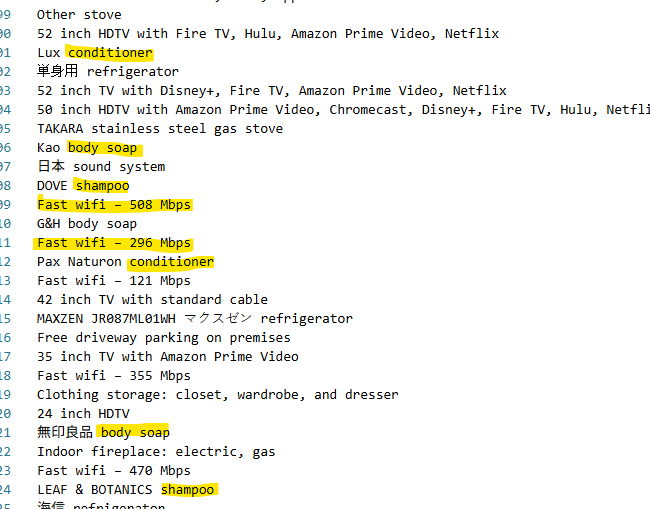

In [ ]:
# 카테고리화 분류

amenity_keywords = {
    "TV/디스플레이": ["hdtv", "tv", "chromecast", "fire tv", "apple tv", "netflix", "hulu", "dvd player", "amazon prime video","standard cable", "premium cable", "roku"],
    "사운드": ["sound system", "speaker"],
    "냉장고/오븐/가전": ["refrigerator", "oven", "microwave", "stainless steel", "induction stove", "gas stove", "electric stove", "single oven", "double oven", "ih", "freezer"],
    "샴푸/린스/바디워시": ["shampoo", "conditioner", "body soap", "トリートメント", "リンス", "ボディソープ", "コンディショナー", "treatment", "body wash", "hair oil", "洗手液", "せっけん", "洗发水", "リンスインシャンプー"],
    "와이파이/인터넷": ["wifi", "ethernet", "pocket wifi", "lan connection"],
    "주차": ["parking", "garage", "driveway", "carport", "parking lot", "parking garage", "street parking"],
    "운동/헬스": ["exercise equipment", "gym", "yoga mat", "shared gym", "stationary bike", "workout bench", "rowing", "treadmill", "elliptical", "climbing wall", "batting cage", "pool", "sauna", "private gym"],
    "어린이/유아": ["high chair", "crib", "children’s books", "children's playroom", "baby bath", "changing table", "table corner guards", "pack ’n play", "travel crib", "booster seat", "baby monitor", "safety gates", "children’s bikes", "children’s dinnerware"],
    "주방/조리도구": ["coffee", "coffee maker", "toaster", "blender", "rice maker", "dishwasher", "keurig", "nespresso", "bbq grill", "barbecue utensils", "kitchen", "kitchenette", "cooking basics", "microwave", "oven", "stove", "hot water kettle", "bread maker", "dishes", "silverware", "baking", "dining table", "wine glass"],
    "사우나/스파/욕조": ["hot tub", "private sauna", "bathtub", "shared hot tub", "spa", "sauna", "shared sauna", "bidet", "shower gel", "hot water"],
    "뷰/전망": ["view", "courtyard view", "garden view", "city skyline view", "mountain view", "sea view", "lake view", "resort view", "bay view", "park view", "canal view", "river view", "ocean view", "harbor view", "valley view", "golf course view", "marina view", "waterfront", "resort access", "beach view", "beach access", "lake access"],
    "보안/안전": ["smoke alarm", "fire extinguisher", "first aid kit", "security camera", "window guards", "smart lock", "keypad", "lockbox", "carbon monoxide alarm", "noise decibel monitors", "lock on bedroom door", "outlet covers", "fireplace guards", "safe"],
    "난방/냉방": ["air conditioning", "central heating", "portable heater", "ceiling fan", "heating", "fan", "window ac", "radiant heating", "split type", "portable air conditioning", "indoor fireplace"],
    "세탁/건조": ["washer", "dryer", "laundromat", "laundry", "free washer", "paid washer", "free dryer", "paid dryer", "drying rack"],
    "반려동물": ["pets allowed"],
    "게임/오락": ["game", "arcade", "console", "board game", "ping pong", "bowling", "mini golf", "life size game"],
    "야외/정원": ["backyard", "outdoor", "patio", "balcony", "hammock", "sun lounger", "fire pit", "fenced", "private entrance", "private living room", "shared backyard", "shared beach access", "outdoor shower", "outdoor furniture", "outdoor playground", "sun loungers"],
    "의류/수납": ["clothing storage", "closet", "dresser", "wardrobe", "hanger"],
    "스포츠/레저": ["bike", "kayak", "hockey", "piano", "skate ramp", "boat slip"],
    "도서/문화": ["book", "reading", "record player", "movie theater", "theme room"],
    "기타": [
        "Bed linens", "ev charger", "elevator", "iron", "mosquito", "mini fridge",
        "room-darkening", "single level", "smoking", "trash compactor", "breakfast",
        "private patio", "private backyard", "private backyard – fully fenced",
        "private backyard – not fully fenced", "private patio or balcony",
        "shared patio or balcony", "shared backyard – fully fenced",
        "shared backyard – not fully fenced", "babysitter recommendations",
        "extra pillows and blankets", "long term stays allowed", "mosquito net",
        "outdoor dining area", "patio or balcony", "private entrance",
        "private living room", "room-darkening shades", "self check-in",
        "shared backyard", "shared backyard – fully fenced",
        "shared backyard – not fully fenced", "shared beach access",
        "shared beach access – beachfront", "shared patio or balcony",
        "single level home", "smoking allowed", "housekeeping", "building staff",
        "host greets you", "cleaning available", "essentials", "luggage dropoff",
        "cleaning products", "dinnerware", "babysitter", "extra pillow",
        "blanket", "long term"
    ]
}

In [ ]:
amenities_ser2 = amenities_ser.copy()


def classify_amenities(amenities_list):
    new_list = []

    # Series 객체의 반복 가능 값 반복
    for amnt in amenities_list:

        for key,value in amenity_keywords.items():
            for key_word in value:
                if key_word.lower() in amnt.lower():
                    new_list.append(key)
                    is_changed = True
                    break
        
        if not is_changed:
            new_list.append('기타')
        
    return list(set(new_list))


amenities_ser2 = amenities_ser2.apply(classify_amenities)

amenities_ser2

amenities 컬럼 카데고리로 분류 가능함을 알게됨 회의를 통해 상세 규칙 설정 필요

---
**중간정리**
- 'review_scores_rating' 칼럼 제외 review_scores 관련 컬럼 모두 제거 필요
- 'latitude', 'longitude' 위도, 경도 컬럼은 'neighbourhood_cleansed'로도 충분히 대체 가능
- 'number_of_reviews', 'number_of_reviews_l30d', 'review_range' 의미가 있을 것으로 보임
- amenities 컬럼 카데고리로 분류 가능함을 알게됨 회의를 통해 상세 규칙 설정 필요

---

### 5. 데이터 정제 및 전처리

In [ ]:
# review_scores_rating 제외 평점 관련 칼럼 모두 제거

drop_scores_list = [
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]
df_listings = df_listings.drop(drop_scores_list, axis=1)

In [ ]:
# 'latitude' 위도, 'longitude' 경도 컬럼은 제거
drop_list = ['longitude', 'latitude']

df_listings = df_listings.drop(drop_list, axis=1)

In [ ]:
df_listings.columns

In [ ]:
df_listings.to_csv('./data/listings.csv')